# Non-EEG Biosignals Dataset Analysis

In [2]:
import os
from collections import Counter
import glob

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.interpolate import interp1d
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib.pyplot import plot as plt

from src.dataset.create_dataset import DataframePrepAllMod 
from src.dataset.dataset_hr import DataframePrepHR
from src.utils.plot import plot_modalities
from src.utils.utils import load_csv_to_dataframe

# Set the current working directory
os.chdir('../')

# Display the current working directory
%pwd


2023-11-20 20:31:41.841093: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 20:31:41.863519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 20:31:41.863544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 20:31:41.863559: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 20:31:41.868011: I tensorflow/core/platform/cpu_feature_g

## Dataset chart for single modality: Heartrate

 The dataset consists of data collected from 20 different college (14 males, 6 females) subjects. <br /> It has data from 5 different modalities: Electrodermal Activity, Temperature, 3D-Accelerometer, Heart rate, and Arterial oxygen saturation. <br /> For the preliminary experiments, we begin by considering only one modality: Heart rate

In [3]:
# Creation of dataset chart with durations for different classes and subjects for Heartrate

dataset_df = pd.read_csv('data/dataset/Subjects_all_HR_SpO2.csv') # Importing the dataset
labels = list(np.unique(dataset_df['Label'])) # Creating a list of labels
subjects = list(np.unique(dataset_df['Subject'])) # Creating a list of subjects

df_mod = dataset_df.drop_duplicates(['Subject','Label']).sort_values(by=['Subject','Label']).reset_index(drop=True) # Removing duplicates
df_mod = df_mod.drop(columns=['Hour','Minute','Second','HeartRate','SpO2']) # Dropping unnecessary columns

df_mod['Frame count'] = list(dataset_df.groupby(['Subject', 'Label']).size()) # Calculating the duration of each class

label_dict = {}
for i in labels:    
    label_dict[i] = list(df_mod[df_mod['Label']==i]['Frame count'])
    
df_chart = pd.DataFrame(label_dict)
df_chart['Subject'] = subjects
df_chart = df_chart.iloc[:, [7,3,2,4,0,5,1,6]] # Re-arranging classes to show in the order during data collection
df_chart = df_chart.style.set_caption('Dataset chart for 20 subjects with the duration of each class in seconds')
df_chart


,Subject,Relax_1,PhysicalStress,Relax_2,CognitiveStress,Relax_3,EmotionalStress,Relax_4
0,Subject_1,301,329,301,365,301,402,300
1,Subject_10,301,327,301,356,301,400,300
2,Subject_11,301,328,301,356,301,652,299
3,Subject_12,299,327,302,355,301,401,300
4,Subject_13,301,328,301,355,301,401,299
5,Subject_14,301,327,301,355,301,400,300
6,Subject_15,301,325,301,355,301,397,300
7,Subject_16,301,327,301,355,301,401,299
8,Subject_17,304,327,301,357,300,401,299
9,Subject_18,301,329,301,355,301,401,300


## Pre-processing data for one modality: Heartrate

Since the raw data has an unequal duration, for each subject and class, the duration is up/downsampled to 360s (6min). Further, to have segments of appropriate fixed durations, the data is chunked to 60s (1min) long segments. 

In [4]:
# Instantiate the class
preprocessor = DataframePrepHR(subjects=SUBJECTS, label=LABELS)

# Assuming 'your_dataframe' is the DataFrame you want to process
processed_dataframe = preprocessor.dataframe_prep_hr(df_hr_spo2)

NameError: name 'DataframePrepHR' is not defined

In [ ]:
processed_dataframe

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,Label,Label_ori,Subject
0,89.000000,88.164345,87.328691,87.000000,87.000000,87.000000,86.986072,86.150418,85.314763,85.000000,...,74.710306,74.000000,74.000000,73.203343,73.000000,73.000000,72.696379,0,Relax_1,Subject_1
1,71.860724,71.025070,71.000000,70.353760,70.000000,70.000000,70.000000,70.000000,70.824513,71.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.607242,69.000000,0,Relax_1,Subject_1
2,69.000000,69.114206,69.949861,70.785515,70.378830,70.000000,70.000000,70.000000,70.000000,70.000000,...,71.000000,71.000000,71.000000,70.924791,70.089136,70.000000,70.000000,0,Relax_1,Subject_1
3,70.417827,71.000000,71.000000,71.000000,71.760446,72.000000,71.568245,71.000000,70.896936,70.061281,...,77.000000,77.543175,78.000000,78.000000,77.949861,77.114206,77.000000,0,Relax_1,Subject_1
4,76.442897,76.000000,75.771588,75.000000,75.000000,74.264624,74.000000,74.000000,73.757660,73.000000,...,79.846797,78.635097,76.963788,76.000000,75.810585,75.000000,75.000000,0,Relax_1,Subject_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,77.000000,77.000000,77.000000,77.584958,80.618384,82.000000,84.150418,86.651811,87.000000,89.640669,...,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,74.409471,3,EmotionalStress,Subject_9
2,74.000000,74.000000,73.066852,74.000000,74.000000,74.000000,74.000000,74.000000,74.618384,75.000000,...,76.000000,75.128134,75.000000,74.000000,74.000000,74.328691,75.000000,3,EmotionalStress,Subject_9
3,75.000000,75.000000,73.428969,73.000000,72.000000,72.000000,72.000000,72.000000,72.000000,73.169916,...,75.610028,76.724234,77.000000,77.000000,78.000000,78.362117,80.000000,3,EmotionalStress,Subject_9
4,80.000000,80.000000,79.362117,79.000000,78.133705,78.000000,77.000000,77.000000,77.000000,77.000000,...,75.000000,75.000000,75.000000,75.805014,76.000000,76.033426,76.852368,3,EmotionalStress,Subject_9


## Multimodal analysis

Sensors for Heartrate and SpO2 are sampled at a frequency of 1Hz found in 'data/dataset/Subjects_all_HR_SpO2.csv'  <br /> 
whereas the remaining sensors are sampled at 8Hz found in 'data/dataset/Subjects_all_AccTempEDA.csv'

When dealing with sensor data collected at different sampling rates, it is important to synchronize the datasets to ensure that they can be analyzed collectively. This synchronization often involves either upsampling, which is increasing the sampling rate of the data by interpolating additional points between the existing data points, or downsampling, which is reducing the sampling rate by aggregating. The goal is to bring all data streams to a common temporal resolution so that meaningful relationships between the sensors can be established and analyzed.

In [14]:
# Loading the datasets and defining lists of labels, subjects, and different modalities according to availability from respective files


df_hr_spo2 = load_csv_to_dataframe('data/dataset/Subjects_all_HR_SpO2.csv')
df_acc_temp_eda = load_csv_to_dataframe('data/dataset/Subjects_all_AccTempEDA.csv')


In [1]:
# Instantiate the class to create the dataframe for all modalities 
allmod = DataframePrepAllMod(subjects=SUBJECTS, label=LABELS, modals=MODALS, modals_1=MODALS_1, modals_2=MODALS_2, 
                                hr_spo2_file='data/dataset/Subjects_all_HR_SpO2.csv',   acc_temp_eda_file='data/dataset/Subjects_all_AccTempEDA.csv')

df_allmod = allmod.dataframe_prep_allmod()
df_allmod

NameError: name 'DataframePrepAllMod' is not defined

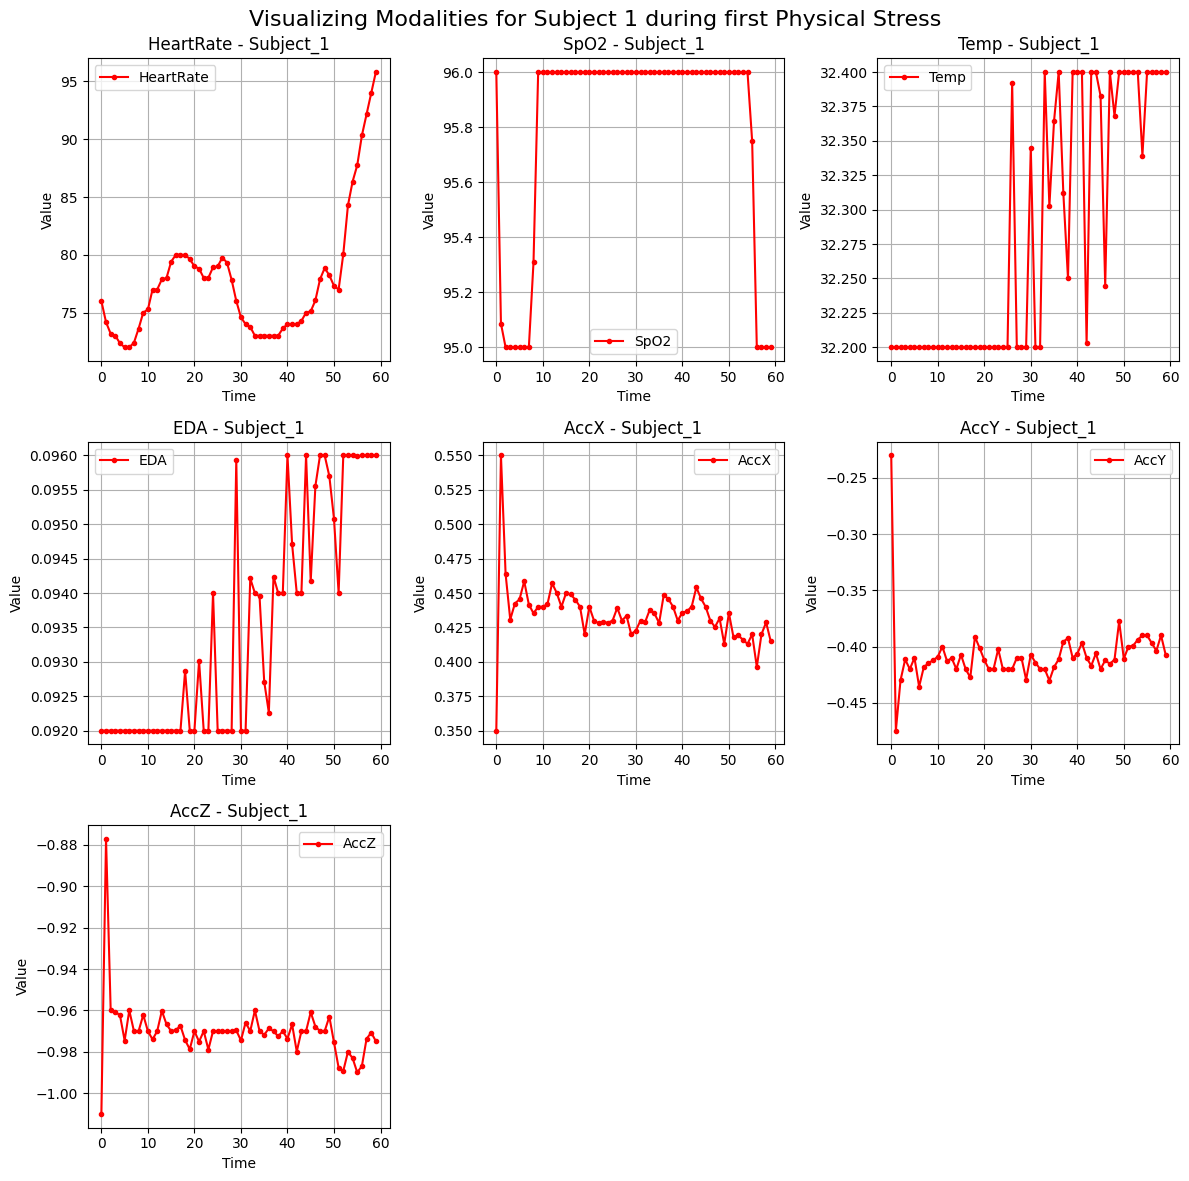

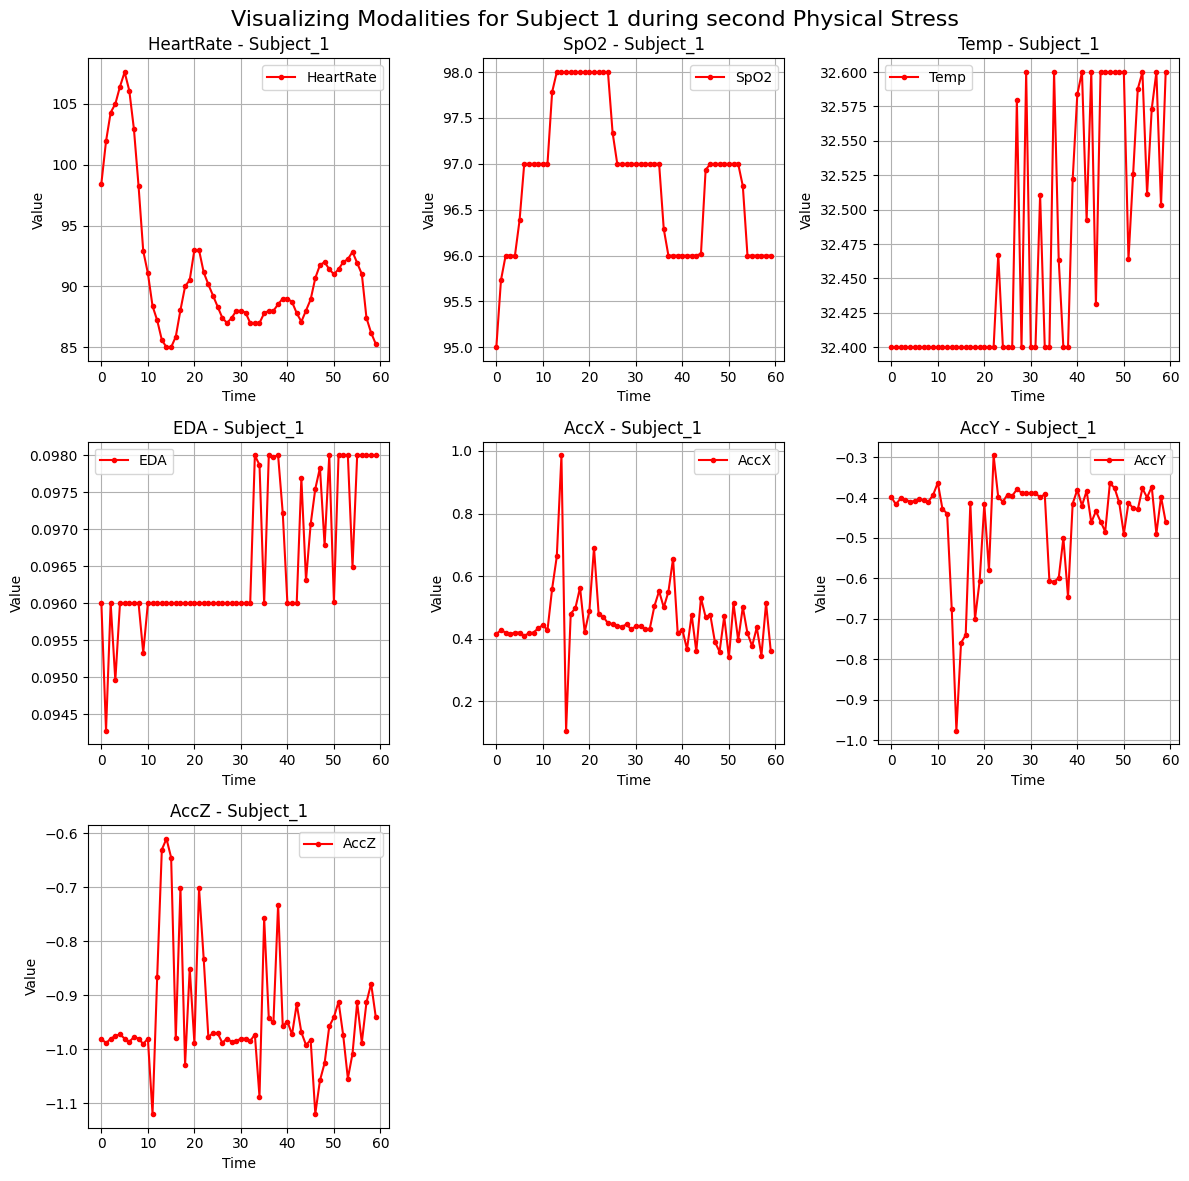

In [16]:
# Example usage:
plot_modalities(df_allmod, 'Subject_1', MODALS, segment=24, num_rows=3, num_cols=3, 
                figsize=(12, 12), common_title='Visualizing Modalities for Subject 1 during first Physical Stress')

# Example usage:
plot_modalities(df_allmod, 'Subject_1', MODALS, segment=25, num_rows=3, num_cols=3, 
                figsize=(12, 12), common_title='Visualizing Modalities for Subject 1 during second Physical Stress')